# Bayesian random effects meta analysis for MCQ and BMI

From a list of Pearson correlation coefficients and corresponding sample sizes, we are going to infer the population level true correlation coefficient.

**Acknowledgement:** Development of the Bayesian meta analysis code greatly benefited from advice from Joachim Vandekerckhove.

The amount of code needed to run the meta analysis is minimal...
```python
import metaBayes.correlation as bm_corr
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/meta_analysis/meta_analysis_correlations_money.csv')

results, posterior = bm_corr.fit(data)

bm_corr.plot(results, posterior, sort_by='effect_size')
plt.savefig('meta_analysis.pdf')

results.to_csv('meta_analysis_results.csv')
```

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import metaBayes.correlation as bm_corr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm  # optionally used for diagnosing the MCMC trace
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
pm.__version__

'3.7'

In [4]:
sample_options = {'tune': 5_000, 'draws': 10_000,
                  'chains': 4, 'cores': 2,
                  'nuts_kwargs': {'target_accept': 0.97},
                  'random_seed': 12345}

## Import and sort the data by effect size


In [5]:
data = pd.read_csv('data/meta_analysis/meta_analysis_correlations_money_amlung.csv')
data

,study,R,N,pub_year,in_amlung2016,bmi_measure,discount_measure,discount_location,Notes
0,Appelhans et al (2011),-0.130,62.0,2011.0,yes,NaN,AUC,NaN,NaN
1,Appelhans et al (2012),NaN,78.0,2012.0,yes,NaN,AUC,NaN,correlation coefficient not reported
2,Borghans & Golsteyn (2006),0.096,2059.0,2006.0,yes,NaN,k,NaN,seemingly used k not ln(k) scores
3,Brace & Yeomans (2016),0.300,80.0,2016.0,yes,NaN,AUC,table 3,reversed effect size due to AUC measure
4,Chabris et al (2008) cognition study,0.240,103.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R
5,Chabris et al (2008) web study,0.176,326.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R
6,Chabris et al (2008) weight study,0.280,126.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R
7,Dassen et al (2015),0.240,151.0,2015.0,yes,NaN,lnk,NaN,"only using the MCQ result, not MCQ-snack"
8,Duckworth et al (2010),0.220,105.0,2010.0,yes,NaN,composite,NaN,Composite self-control score of Kirby and real...
9,Epstein et al (2003) computer measure,-0.057,78.0,2003.0,yes,NaN,lnk,NaN,NaN


## Important: Reverse effect sizes for AUC measures
Higher $\log(k)$ scores means greater discounting, but higher AUC scores mean lower discounting. Therefore we will reverse the effect sizes (correlation coefficients) for studies reporting AUC. We will do this by adding a column to indicate we want to reverse the effect size for studies which used AUC as the measure of discounting. The actual reversal happens inside the meta analysis code. 

In [6]:
data['reverse_effect_size'] = np.where(data['discount_measure']=='AUC', True, False)
data

,study,R,N,pub_year,in_amlung2016,bmi_measure,discount_measure,discount_location,Notes,reverse_effect_size
0,Appelhans et al (2011),-0.130,62.0,2011.0,yes,NaN,AUC,NaN,NaN,True
1,Appelhans et al (2012),NaN,78.0,2012.0,yes,NaN,AUC,NaN,correlation coefficient not reported,True
2,Borghans & Golsteyn (2006),0.096,2059.0,2006.0,yes,NaN,k,NaN,seemingly used k not ln(k) scores,False
3,Brace & Yeomans (2016),0.300,80.0,2016.0,yes,NaN,AUC,table 3,reversed effect size due to AUC measure,True
4,Chabris et al (2008) cognition study,0.240,103.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False
5,Chabris et al (2008) web study,0.176,326.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False
6,Chabris et al (2008) weight study,0.280,126.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False
7,Dassen et al (2015),0.240,151.0,2015.0,yes,NaN,lnk,NaN,"only using the MCQ result, not MCQ-snack",False
8,Duckworth et al (2010),0.220,105.0,2010.0,yes,NaN,composite,NaN,Composite self-control score of Kirby and real...,False
9,Epstein et al (2003) computer measure,-0.057,78.0,2003.0,yes,NaN,lnk,NaN,NaN,False


## Run the Random Effects meta analysis 
Columns which are *required*:
- `R` the Pearson correlation coefficient
- `N` 
- `study` for plotting

Columns which are optional:
- `reverse_effect_size` Should be either `True` or `False` according to whether we need to reverse the effect size. This is useful in some situations which report correlations on measures which are reversed in sign.

In [7]:
results, prior, posterior, model = bm_corr.fit(data, sample_options)

Prior over population effect size: Stretched Beta
Sampling from prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling from posterior


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [z_study, study_sigma, r_pop]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [01:17<00:00, 772.42draws/s]


Estimated true correlation coefficient:
	0.149 [95% HDI: 0.070, 0.224]


Inspect the results - we have additional columns returned to the `results` table.

In [8]:
results

,study,R,N,pub_year,in_amlung2016,bmi_measure,discount_measure,discount_location,Notes,reverse_effect_size,effect_size,effect_size_est_mean,effect_size_est_HDI_lower,effect_size_est_HDI_upper
0,Appelhans et al (2011),-0.130,62.0,2011.0,yes,NaN,AUC,NaN,NaN,True,0.130,0.138030,-0.048928,0.321846
1,Borghans & Golsteyn (2006),0.096,2059.0,2006.0,yes,NaN,k,NaN,seemingly used k not ln(k) scores,False,0.096,0.097413,0.055600,0.139681
2,Brace & Yeomans (2016),0.300,80.0,2016.0,yes,NaN,AUC,table 3,reversed effect size due to AUC measure,True,-0.300,-0.122032,-0.318151,0.071612
3,Chabris et al (2008) cognition study,0.240,103.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False,0.240,0.207843,0.054839,0.361288
4,Chabris et al (2008) web study,0.176,326.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False,0.176,0.171914,0.074471,0.270201
5,Chabris et al (2008) weight study,0.280,126.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False,0.280,0.240487,0.102178,0.383953
6,Dassen et al (2015),0.240,151.0,2015.0,yes,NaN,lnk,NaN,"only using the MCQ result, not MCQ-snack",False,0.240,0.215627,0.078970,0.345730
7,Duckworth et al (2010),0.220,105.0,2010.0,yes,NaN,composite,NaN,Composite self-control score of Kirby and real...,False,0.220,0.195016,0.042420,0.345048
8,Epstein et al (2003) computer measure,-0.057,78.0,2003.0,yes,NaN,lnk,NaN,NaN,False,-0.057,0.027820,-0.149468,0.205851
9,Epstein et al (2014),-0.208,199.0,2014.0,yes,NaN,AUC,NaN,reversed effect size due to AUC measure,True,0.208,0.194568,0.076034,0.315871


## Plot the results

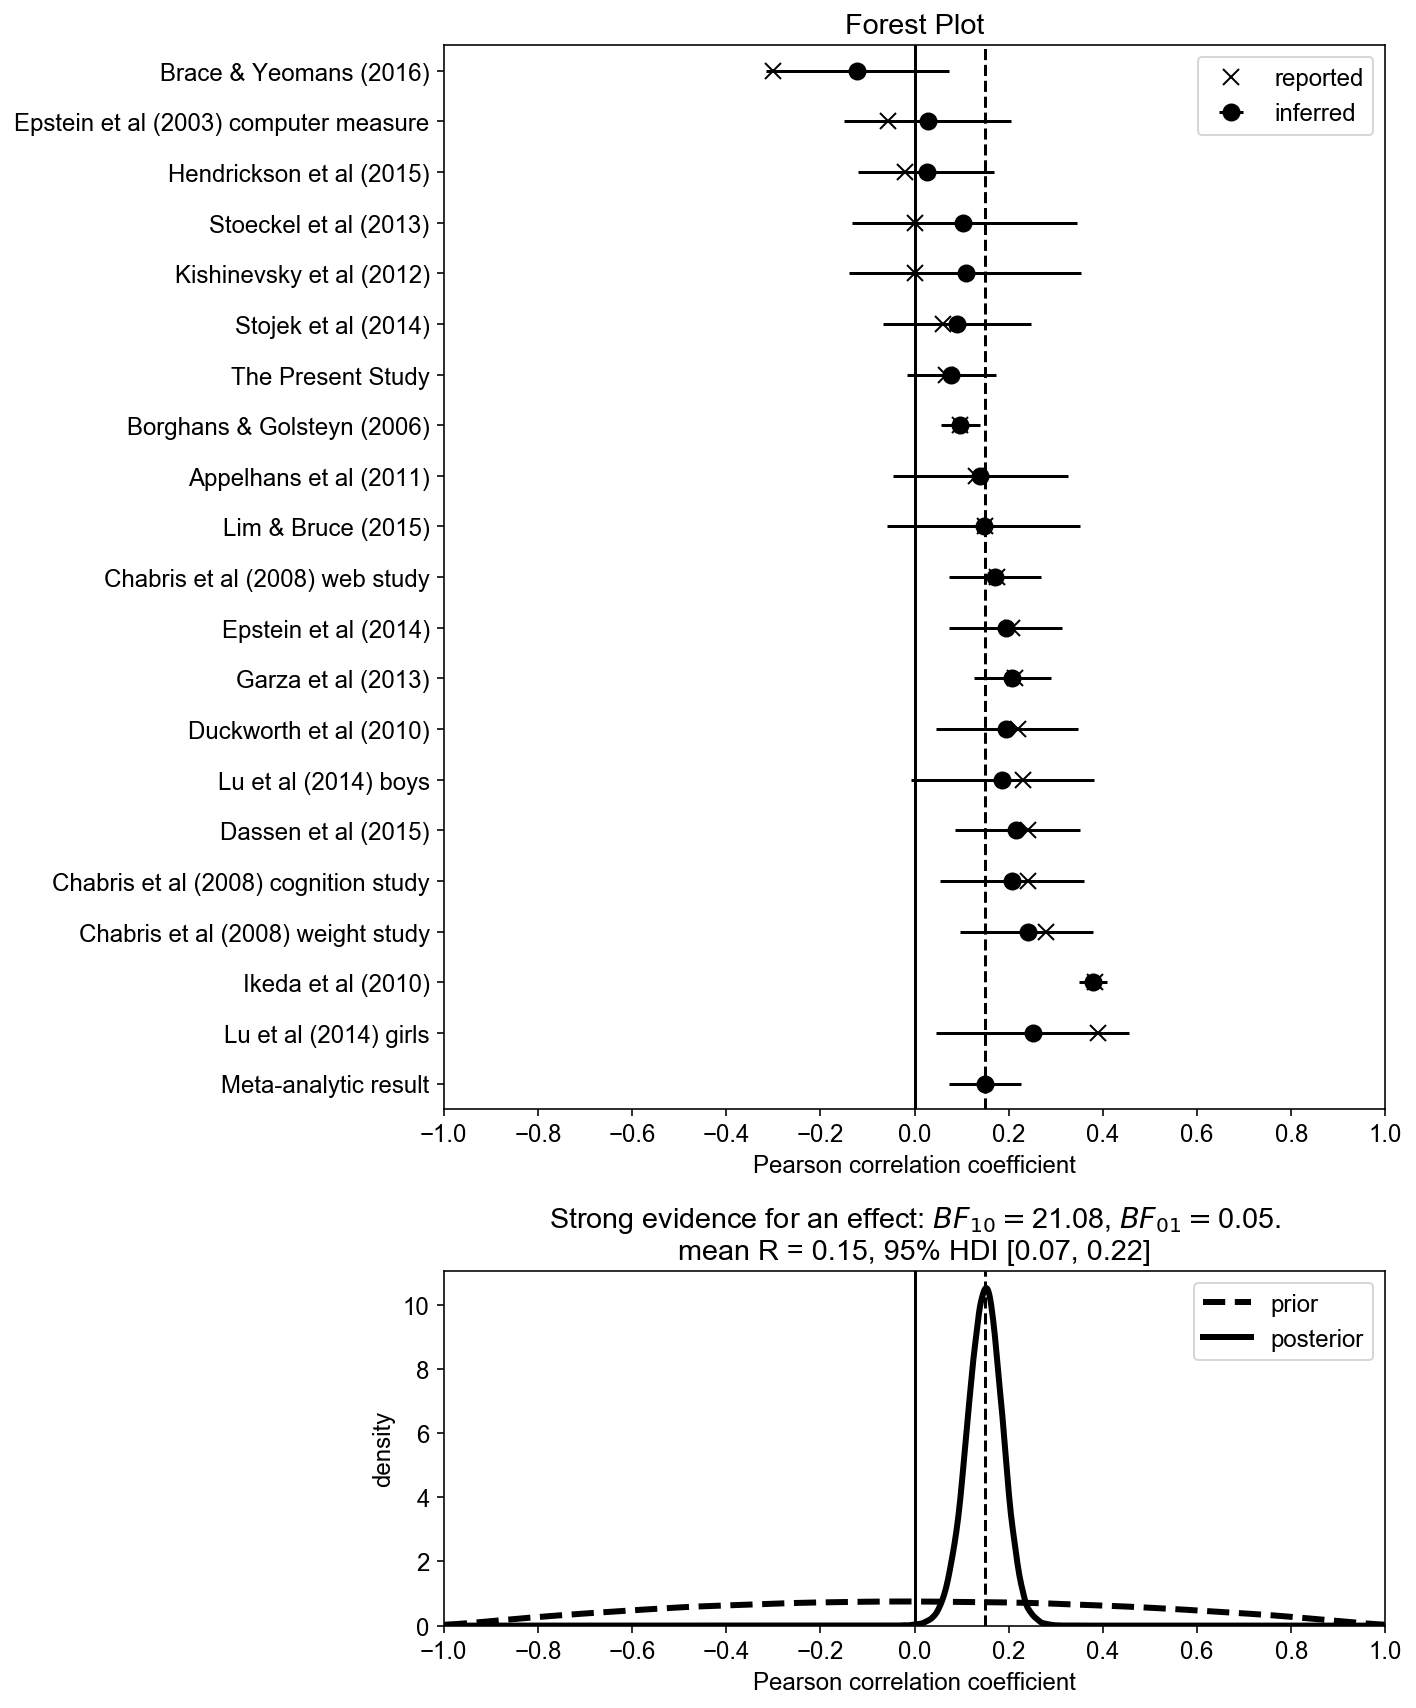

In [9]:
bm_corr.plot(results, prior, posterior, sort_by='effect_size')

plt.savefig('figs/meta_analysis.pdf', bbox_inches='tight')
plt.savefig('img/meta_analysis.png', bbox_inches='tight', dpi=300)

## Inspect and save the results
We can see the meta-analysis results have been appended to the returned `data` dataframe. We have the estimated effect sizes (and 95% highest density intervals) appended as new columns for each study. We also have a new row at the bottom of the table representing the population level estimate (i.e the meta-analytic estimate). This table is useful for inspection and can be saved with something like the following line:
```python
results.to_csv('meta analysis results.csv')
```

In [10]:
results.tail()

,study,R,N,pub_year,in_amlung2016,bmi_measure,discount_measure,discount_location,Notes,reverse_effect_size,effect_size,effect_size_est_mean,effect_size_est_HDI_lower,effect_size_est_HDI_upper
16,Lu et al (2014) girls,-0.390,39.0,2014.0,yes,NaN,AUC,NaN,reversed effect size due to AUC measure,True,0.390,0.250645,0.044978,0.455947
17,Stoeckel et al (2013),0.000,24.0,2013.0,yes,NaN,lnk,NaN,"Didnt report R, just say that it is non-signif...",False,0.000,0.102613,-0.139771,0.338898
18,Stojek et al (2014),0.060,108.0,2014.0,yes,NaN,k,NaN,seemingly used k not ln(k) scores,False,0.060,0.089253,-0.068111,0.245873
19,The Present Study,0.067,381.0,2019.0,no,NaN,lnk,NaN,NaN,False,0.067,0.077182,-0.019336,0.169587
20,Meta-analytic result,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.148565,0.070287,0.224081


In [25]:
results.to_csv('output/meta analysis results - MCQ - random effects.csv')

## Due diligence: checking the MCMC chains
It is very sensible to check that the MCMC chains look good, and devoid of any clear pathologies

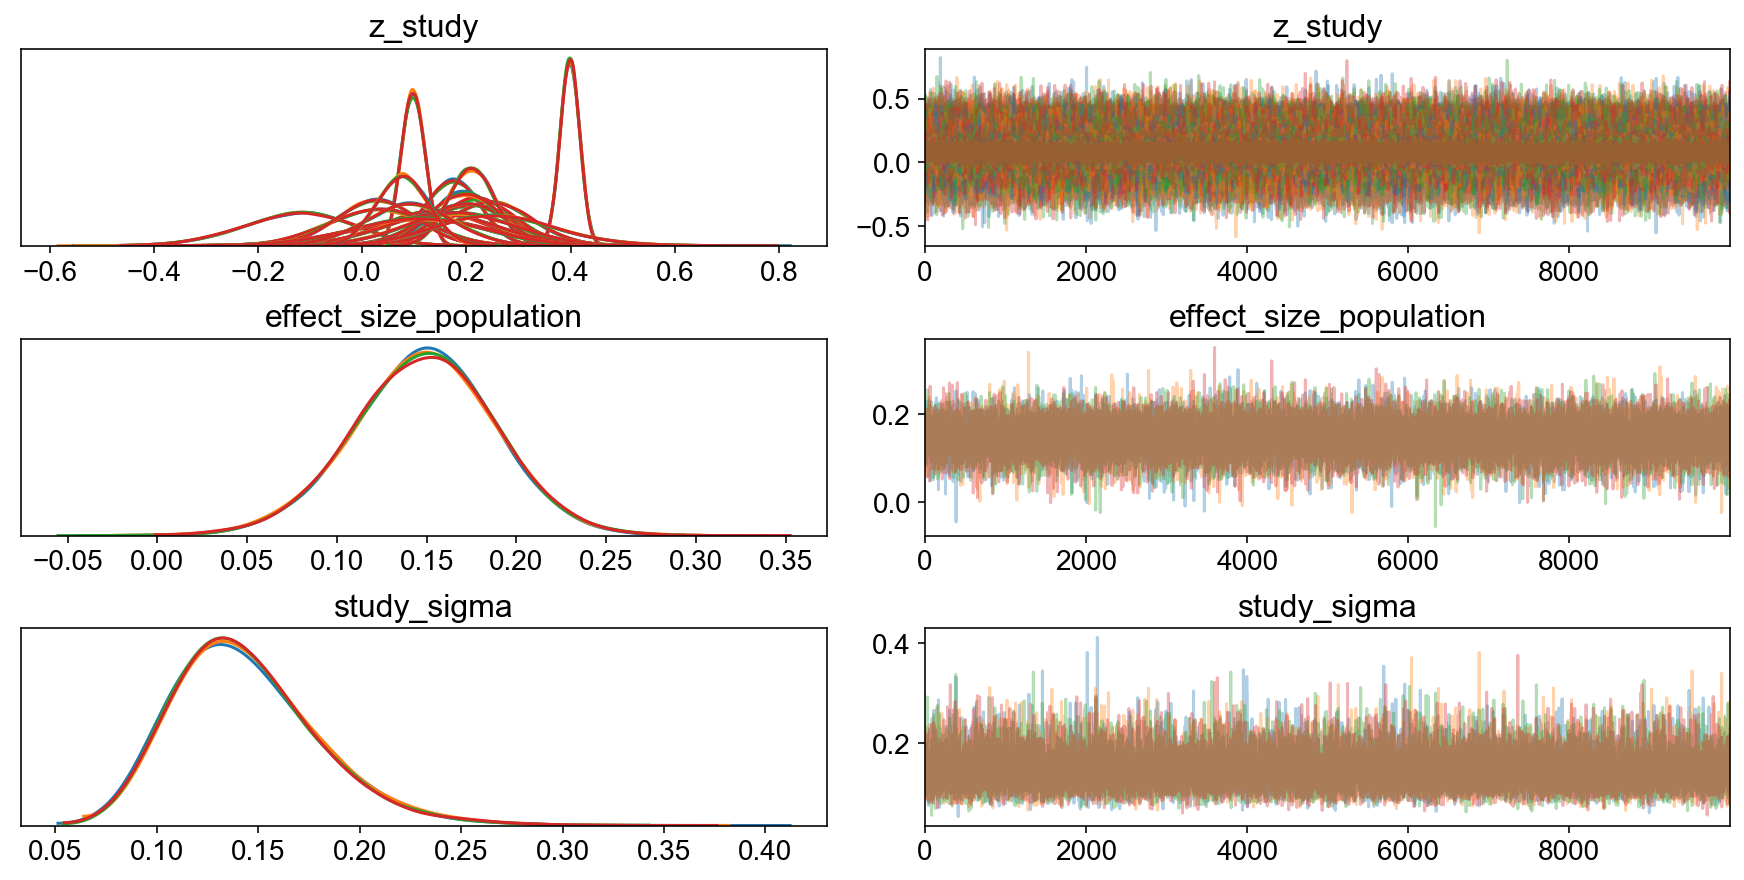

In [11]:
pm.traceplot(posterior, var_names=['z_study', 'effect_size_population', 'study_sigma'], combined=False);

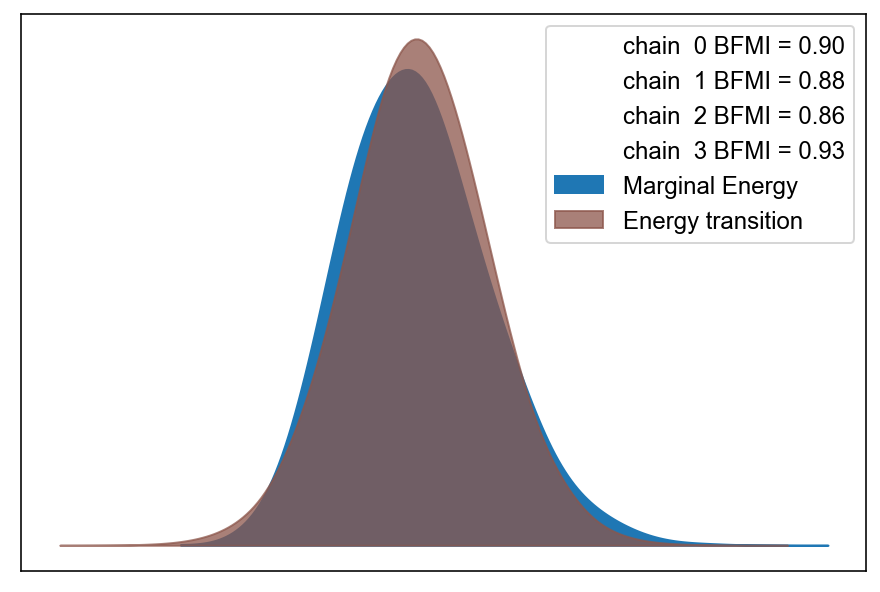

In [12]:
pm.energyplot(posterior);

/anaconda3/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/anaconda3/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


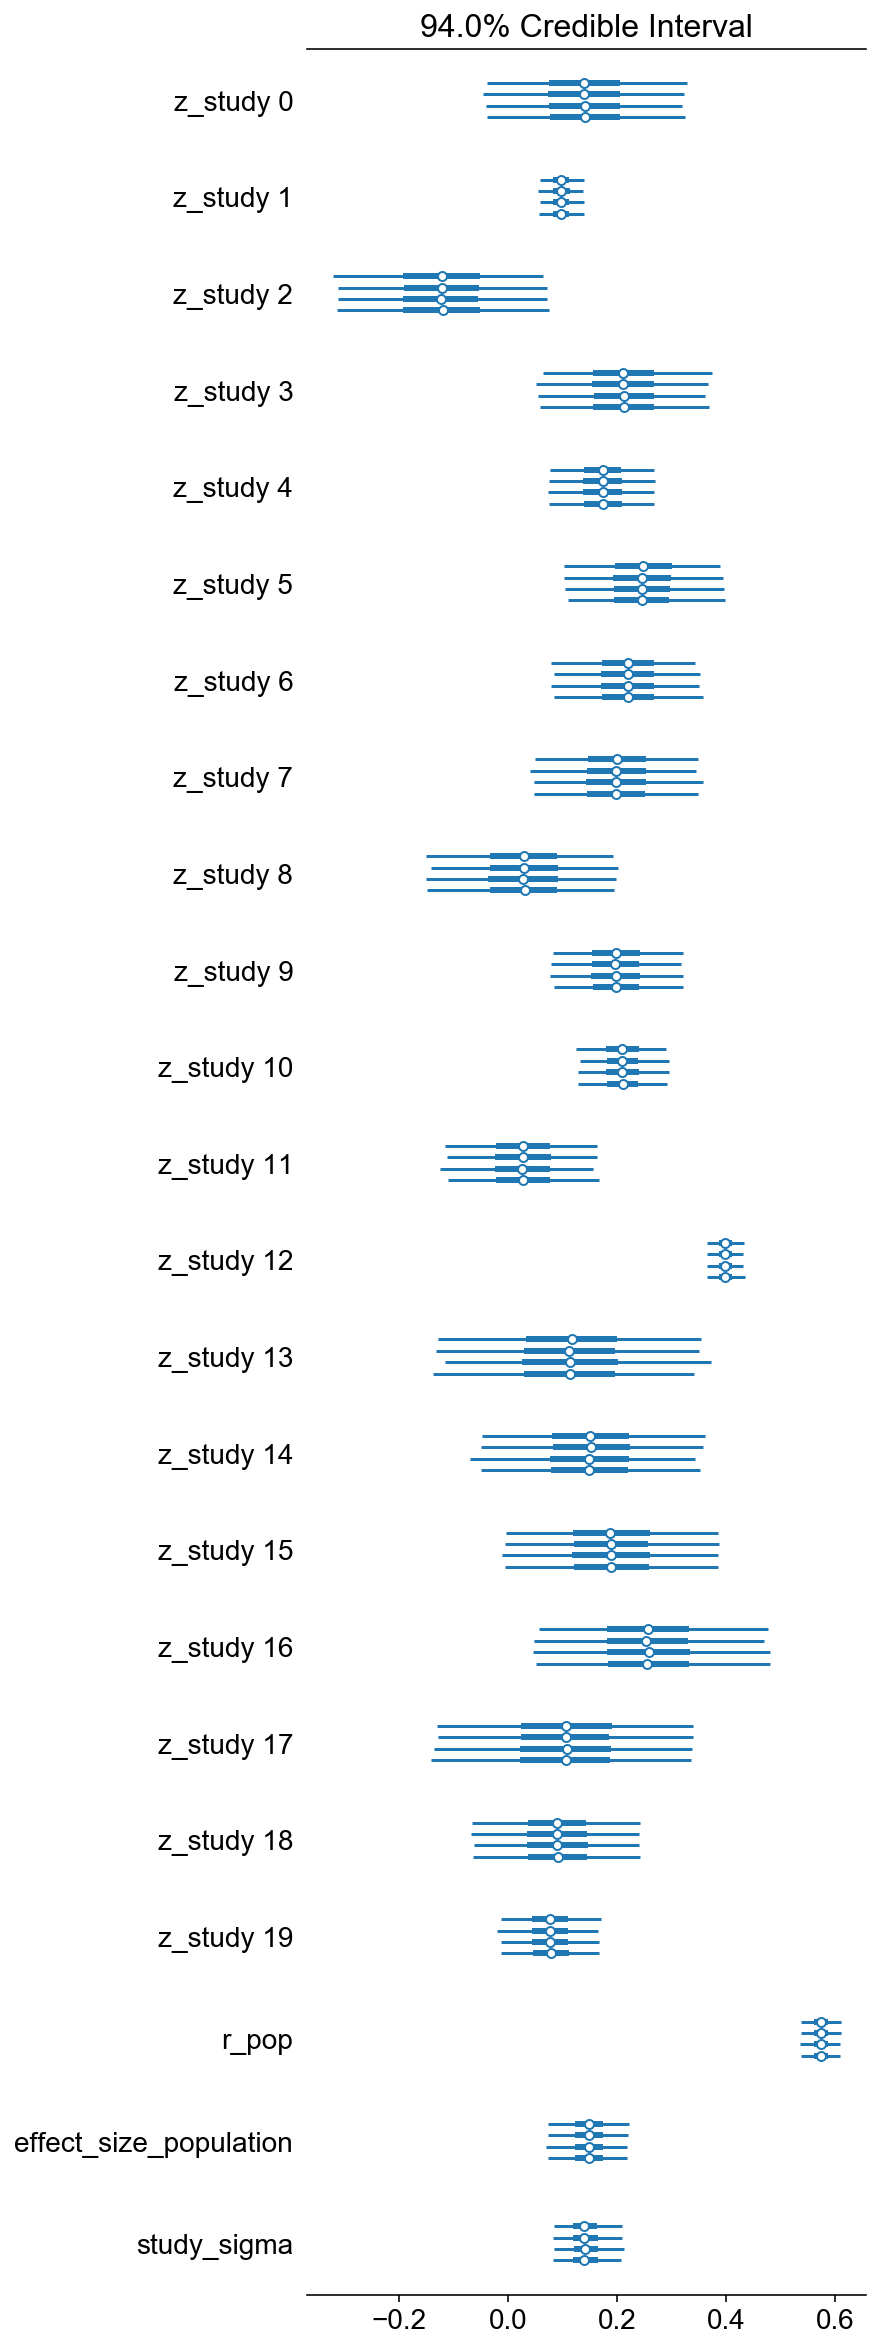

In [13]:
pm.forestplot(posterior);

### Fixed vs random effects model
The model we have is basically a Random Effects model, where study is the random effect. The variable `study_sigma` defines the standard deviation of true study level effect sizes (in z space)
If `study_sigma`=0 then the model becomes equivalent to a Fixed Effects model which basically says that each study is a noisy observation of the population level effect size. In other words, in the Fixed Effects meta analysis there are no true study level effect sizes, just the population level effect size.

So, if `study_sigma`=0 then we have evidence that all the studies are drawing on the same underlying effect size.

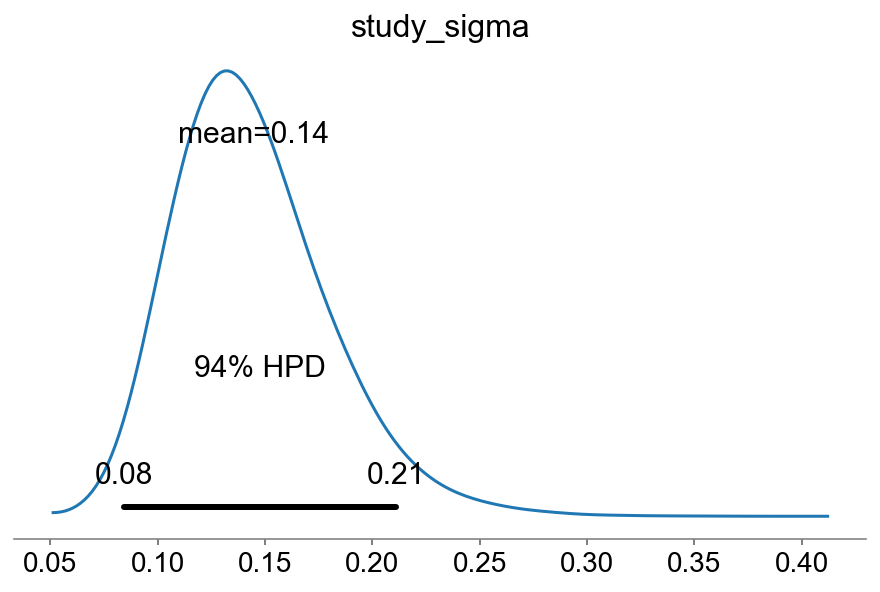

In [14]:
pm.plot_posterior(posterior, var_names='study_sigma', round_to=2);

In [15]:
np.mean(posterior['study_sigma'])

0.14455071252882937

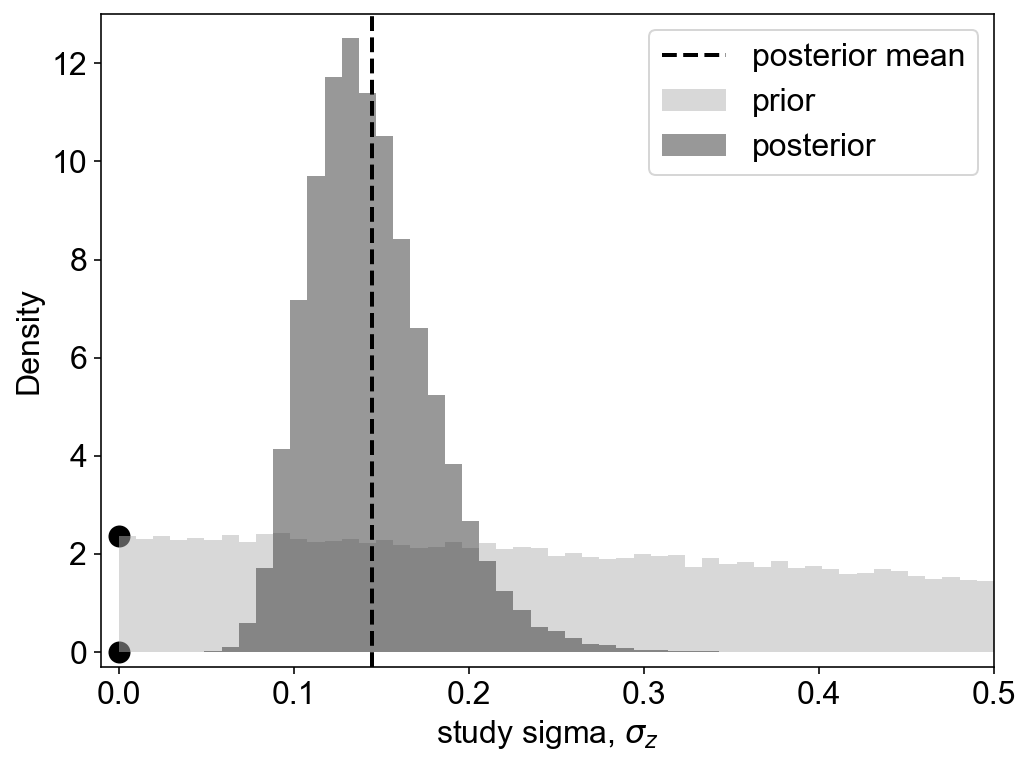

In [16]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(8, 6))

prior_n, prior_bins, collections = ax.hist(prior['study_sigma'], bins=51, density=1, range=(0,0.5), 
                                    color=[0.7, 0.7, 0.7], alpha=0.5, label='prior', lw=0.0)

post_n, post_bins, collections = ax.hist(posterior['study_sigma'], bins=51, density=1, range=(0,0.5), 
                                  color=[0.2, 0.2, 0.2], alpha=0.5, label='posterior', lw=0.0,)

plt.axvline(x=np.mean(posterior['study_sigma']), linewidth=2, c='k', ls='--', label='posterior mean')

ax.scatter(prior_bins[0], prior_n[0], s=10**2, c='k')
ax.scatter(post_bins[0], post_n[0], s=10**2, c='k')

ax.legend()
ax.set(xlim=[-0.01, 0.5], 
       ylim=[-0.3, 13],
       xlabel=r'study sigma, $\sigma_z$', 
       ylabel='Density');

# ax.axes.get_yaxis().set_ticks([])

plt.savefig('figs/study_sigma.pdf', bbox_inches='tight')

In [17]:
bayes_factor = prior_n[0]/ post_n[0]
bayes_factor

inf

But what we find is that the posterior density at `study_sigma`=0 is close to zero. So it looks like the studies here are _not_ all being generated from a core underlying effect size. So there is variation in the study level effect sizes which is coming from _somewhere_ as yet unaccounted for. 

We could test this more quantitatively by looking at the posterior, or by computing Bayes Factors. Although the latter would require a meaningful prior over `study_sigma` (which is in continuous z-space). It's not immediately clear what form this prior should take.

An alternative approach would be to do model comparison with WAIC.

# Funnel plot
Note that we must take the `effect_size` not the `R` variable because the former has had the magnitude flipped properly to compate AUC and dicount rate measures.

In [18]:
results.head()

,study,R,N,pub_year,in_amlung2016,bmi_measure,discount_measure,discount_location,Notes,reverse_effect_size,effect_size,effect_size_est_mean,effect_size_est_HDI_lower,effect_size_est_HDI_upper
0,Appelhans et al (2011),-0.130,62.0,2011.0,yes,NaN,AUC,NaN,NaN,True,0.130,0.138030,-0.048928,0.321846
1,Borghans & Golsteyn (2006),0.096,2059.0,2006.0,yes,NaN,k,NaN,seemingly used k not ln(k) scores,False,0.096,0.097413,0.055600,0.139681
2,Brace & Yeomans (2016),0.300,80.0,2016.0,yes,NaN,AUC,table 3,reversed effect size due to AUC measure,True,-0.300,-0.122032,-0.318151,0.071612
3,Chabris et al (2008) cognition study,0.240,103.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False,0.240,0.207843,0.054839,0.361288
4,Chabris et al (2008) web study,0.176,326.0,2008.0,yes,NaN,k or lnk,NaN,R-squared reported. We converted to R,False,0.176,0.171914,0.074471,0.270201


In [19]:
def SE_of_study(results):
    '''Calculate standard error'''
    return 1 / np.sqrt(results['N']-3)

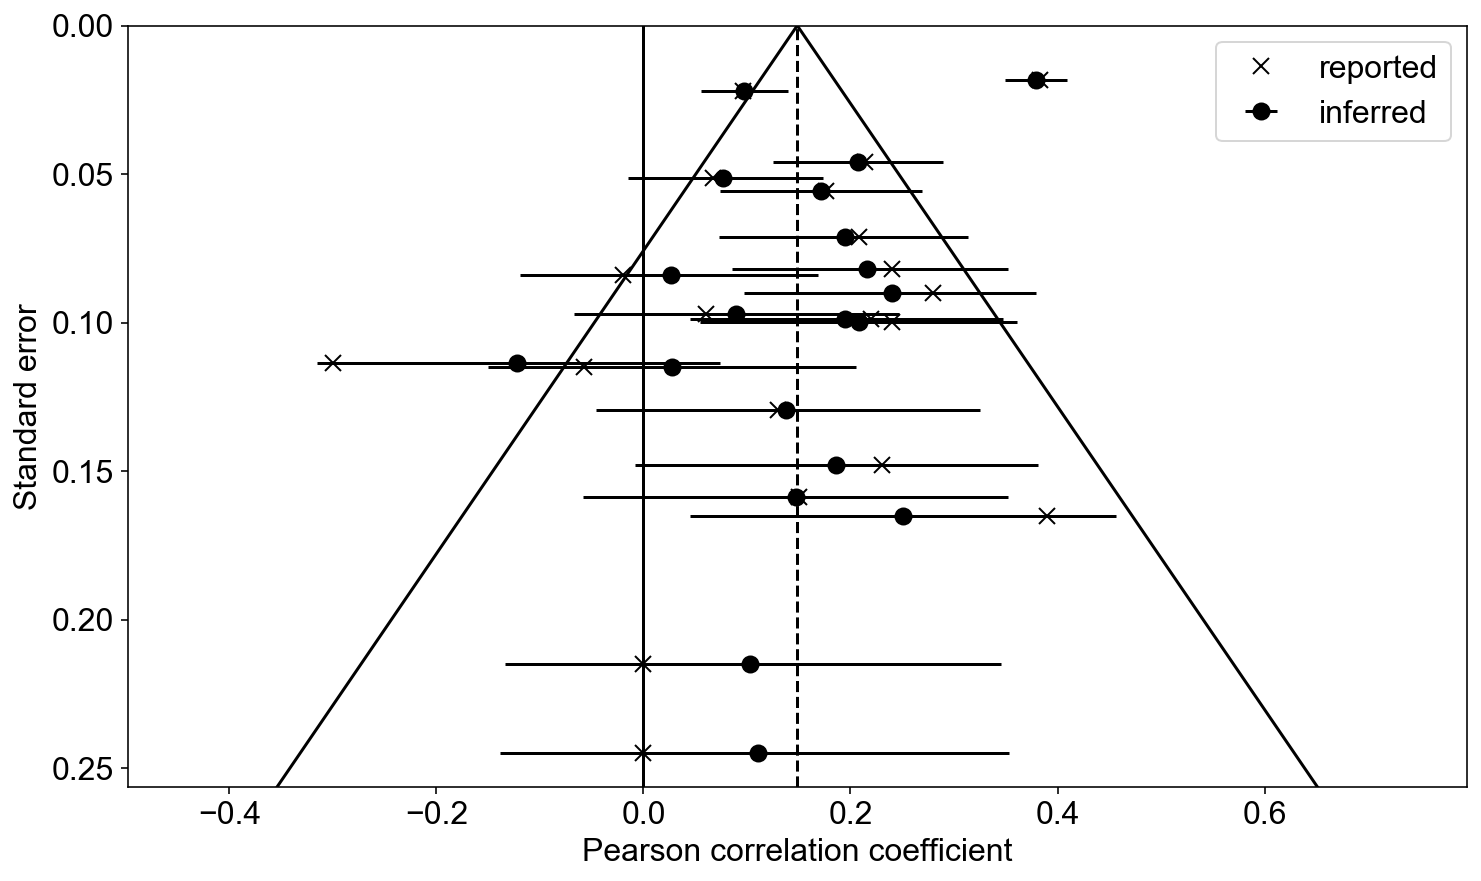

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

marker_size = 8

# plot reported correlation coefficient
ax.plot(results['effect_size'], 
           bm_corr._inverse_fisher_transformation(SE_of_study(results)),
           'x', c='k', markersize=marker_size, label='reported')

# plot inferred correlation coefficient
effect_size_est_mean = results['effect_size_est_mean'].values
effect_size_est_HDI_lower = results['effect_size_est_HDI_lower'].values
effect_size_est_HDI_upper = results['effect_size_est_HDI_upper'].values
ax.errorbar(effect_size_est_mean, 
            bm_corr._inverse_fisher_transformation(SE_of_study(results)),
            xerr=[effect_size_est_HDI_upper - effect_size_est_mean,
                  effect_size_est_mean - effect_size_est_HDI_lower],
            fmt='o', markersize=marker_size, color='k',
            label='inferred')

ax.invert_yaxis()
ax.set_ylim(top=0)

mean_effect_size = np.mean(posterior['effect_size_population'])

# vertical lines
plt.axvline(x=mean_effect_size, c='k', ls='--')

plt.axvline(x=0, c='k')

# diagonal lines: 95% of mass within mean +/- 1.96*SE 
y = np.linspace(0, 0.3, 100)
ax.plot(mean_effect_size - 1.96*y, y, c='k')
ax.plot(mean_effect_size + 1.96*y, y, c='k')

ax.legend()
    
ax.set(xlabel = 'Pearson correlation coefficient',
       ylabel = 'Standard error');

## [not used] Model comparison with Fixed vs Random Effects meta analyses

Experimental use of model comparison for the fixed vs random effects models. But there are some warnings for the WAIC comparison, so we do not rely on this result.

In [21]:
results_re, prior_re, posterior_re, model_re = bm_corr.fit(data, type='random effects')
results_fe, prior_fe, posterior_fe, model_fe = bm_corr.fit(data, type='fixed effects')

random_effects_waic = pm.waic(posterior_re, model_re)
fixed_effects_waic = pm.waic(posterior_fe, model_fe)

model_re.name = 'random effects'
model_fe.name = 'fixed effects'

Prior over population effect size: Stretched Beta
Sampling from prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling from posterior


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [z_study, study_sigma, r_pop]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:45<00:00, 870.19draws/s]


Estimated true correlation coefficient:
	0.149 [95% HDI: 0.072, 0.224]
Prior over population effect size: Stretched Beta
Sampling from prior


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling from posterior


Multiprocess sampling (4 chains in 2 jobs)
NUTS: [r_pop]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:15<00:00, 2647.37draws/s]
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


Estimated true correlation coefficient:
	0.231 [95% HDI: 0.209, 0.251]


/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


Do WAIC comparison

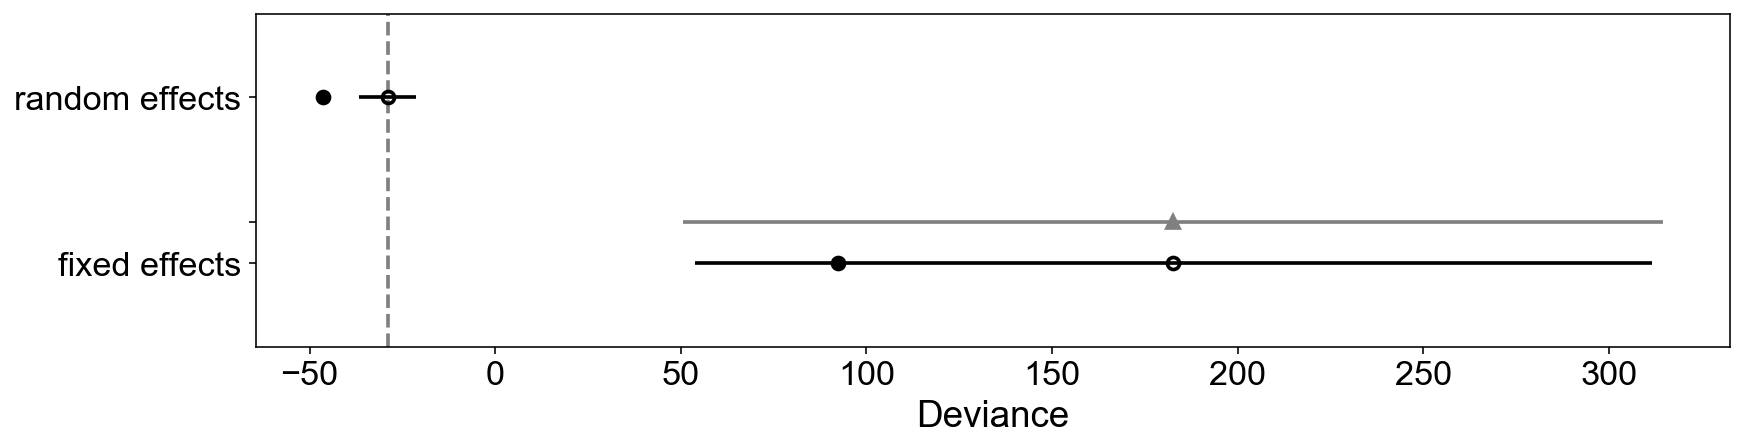

In [22]:
df_comp_WAIC = pm.compare({model_re: posterior_re,
                           model_fe: posterior_fe})
df_comp_WAIC
pm.compareplot(df_comp_WAIC, figsize=(12,3));

In as much as the WAIC model comparison can be trusted (see warnings) then the fixed effects model is much worse than the random effects model. This corroborates the notion that there is a meaningful amount of study level variance that we got from looking at the `study_sigma` variable in the random effects analysis.